# Compare smoothed waveforms

Experimental/simulation data have already been processed into time series of smoothed harmonics.

Settings.inp constains parameters for this script as well as the harmonic splitter used to get the smoothed harmonics. Also includes the weights for each harmonic. Settings and the script are both made by GenerateScript.py

This script should not need to be modified by general users. All done via the settings.inp file which is created by the "GenerateScript" python notebook.

There is a plotting option at the bottom of this script that can be activated manually - leave turned off for running with the bash script.

### Load packages

In [4]:
# import required python packages
import numpy as np
import pandas as pd

## Read settings

From file "Settings.inp"

In [5]:
lines = [line.rstrip('\n') for line in open('Settings.inp')]
filename = lines[0].strip().split()[0]
number_harmonics = int(lines[1].strip().split()[0])
frequency_bandwidth = float(lines[2].strip().split()[0])
iUseSingleMetric = int(lines[3].strip().split()[0]) # =0 or =1
i_use_weights = int(lines[4].strip().split()[0])
weights = np.fromstring(lines[5].strip(), dtype=float, sep=',')

Hard wired filenames for comparison

In [6]:
# input the total number of frequencies to check; i.e. all frequencies, harmonics, cross harmonics etc
# specified in harmonic splitter when this was created
n_freq = number_harmonics

# file names
filename_exp = 'ExpSmoothed.txt'
filename_sim = 'Smoothed.txt'

# interactive
plotInteractive = False

# weights file (made by generate script?)

## Define functions

Read smoothed time series data. Generalise to take any number of harmonics and weights.
For example we have 2 input frequencies and the 2nd harmonic of the 1st input frequency is more important.

First is time, second is dc, after that there are N harmonics

In [7]:
def ReadSmoothed(filename):
    f = open(filename, 'r')
    input_data = []
    for line in f:
        input_data.append(line.split())
    input_array = np.array(input_data, dtype=float)
    return input_array

Simple least squares function scaled by the sum of squares of the first input function - used for comparison. 

Combine these by weights to get the final metric.

This assumes that they perfectly align (they do on the test case and rest made by MECSim so should too)

In [8]:
def LeastSquares(y1, y2): # first is the basis for comparision
    S = 0.0
    X = 0.0
    for i in range(len(y1)):
        S += (y1[i]-y2[i])**2.
        X += y1[i]**2.
    return S/X

## Read files

In [9]:
smoothed_exp = ReadSmoothed(filename_exp)
smoothed_sim = ReadSmoothed(filename_sim)

### Check files

Check file structure for correct number of harmonics

In [10]:
n_found_harm_exp = len(smoothed_exp[0, :]) - 2
n_found_harm_sim = len(smoothed_sim[0, :]) - 2
if(number_harmonics!=n_found_harm_sim) or (number_harmonics!=n_found_harm_exp):
    print "WARNING: inconsistent number of harmonics (excluding dc)"
    print "Settings n_harm=", number_harmonics
    print "Experimental data n_harm=", n_found_harm_exp
    print "Simulation data n_harm=", n_found_harm_sim

## Calculate metric

Number of harmonics and dc first (so +1 for range). Also dont need to compare time (index=0)

In [16]:
Smetric = 0.0
S = []
for i in range(number_harmonics+1):
    Sharm = LeastSquares(smoothed_sim[:, i+1], smoothed_exp[:, i+1])*weights[i]
    Smetric+=Sharm
    S.append(Sharm)


## Write to single metric to output


Outputs a single value for the comparison metric. This is picked up by an echo command in the looping script. There it is combined with the input parameters and appended to the Results.txt output file from the whole loop.

In [21]:
if(iUseSingleMetric==1): # use total metric
    print Smetric
else: # use each harmonic split by commas
    SHText = ','.join(map(str, S))
    print SHText


0.00239316551775,0.0185011310233,0.0708356468267,0.0616338039213,0.0509735342243,0.0198786937865,0.0107277316162


## Use interactive plotter

ONLY if not using this in bash script.

Simulation in red, experimental data in black. Harmonic 0 is dc and this example goes up to the 5th harmonic.

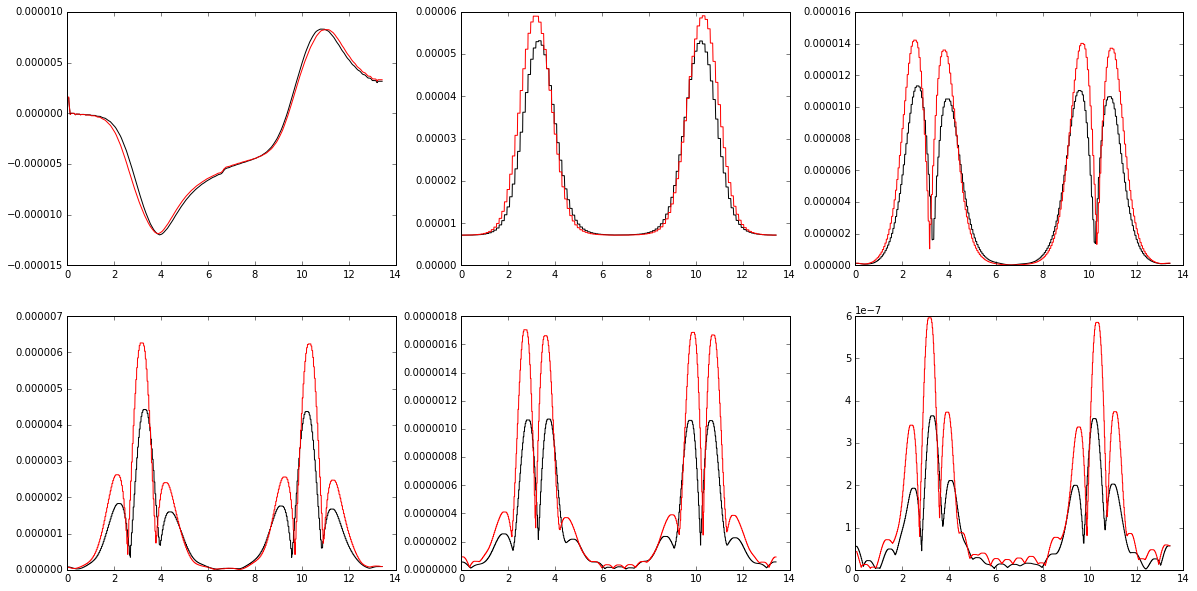

In [145]:
if(plotInteractive):
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.figure(figsize=(20,10))
    plt.subplot(231)
    i_harm = 0
    plt.plot(smoothed_exp[:, 0], smoothed_exp[:, i_harm+1], c='k')
    plt.plot(smoothed_sim[:, 0], smoothed_sim[:, i_harm+1], c='r')
    plt.subplot(232)
    i_harm = 1
    plt.plot(smoothed_exp[:, 0], smoothed_exp[:, i_harm+1], c='k')
    plt.plot(smoothed_sim[:, 0], smoothed_sim[:, i_harm+1], c='r')
    plt.subplot(233)
    i_harm = 2
    plt.plot(smoothed_exp[:, 0], smoothed_exp[:, i_harm+1], c='k')
    plt.plot(smoothed_sim[:, 0], smoothed_sim[:, i_harm+1], c='r')
    plt.subplot(234)
    i_harm = 3
    plt.plot(smoothed_exp[:, 0], smoothed_exp[:, i_harm+1], c='k')
    plt.plot(smoothed_sim[:, 0], smoothed_sim[:, i_harm+1], c='r')
    plt.subplot(235)
    i_harm = 4
    plt.plot(smoothed_exp[:, 0], smoothed_exp[:, i_harm+1], c='k')
    plt.plot(smoothed_sim[:, 0], smoothed_sim[:, i_harm+1], c='r')
    plt.subplot(236)
    i_harm = 5
    plt.plot(smoothed_exp[:, 0], smoothed_exp[:, i_harm+1], c='k')
    plt.plot(smoothed_sim[:, 0], smoothed_sim[:, i_harm+1], c='r')
    plt.show()